# **Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm**
### *Course:* Advanced Statistics for Physics Analysis, University of Padua, A.Y. 2021/22
### *Students:* Francesco Pio Barone, Gianmarco Nagaro Quiroz, Daniele Ninni
***
## **Table of Contents**
1) [**Implementation of the K2 algorithm**](#sec1)
    - 1.A [$\texttt{k2}$](#sec1.A)
    - 1.B [$\texttt{f}$](#sec1.B)
    - 1.C [$\texttt{log.f}$](#sec1.C)
    - 1.D [$\texttt{k2.iter}$](#sec1.D)
2) [**Test of the implementation**](#sec2)
    - 2.A [*CH93*](#sec2.A)
    - 2.B [*ASIA*](#sec2.B)
    - 2.C [*SACHS*](#sec2.C)
    - 2.D [*CHILD*](#sec2.D)
***

In [1]:
# load packages
library(tidyverse) |> suppressPackageStartupMessages()
library(bnlearn)   |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()

<a id='sec1'></a>
## **1** - Implementation of the K2 algorithm

<a id='sec1.A'></a>
### **1.A** $\texttt{k2}$

In [2]:
k2 <- function(dataset, parents.nmax, f) {

        nodes   <- names(dataset)           # node names
        net.dag <- empty.graph(nodes=nodes) # network DAG (Directed Acyclic Graph)

        for (i in 2:length(nodes)) {

            node           <- nodes[i]                  # current node
            previous.nodes <- nodes[1:(i-1)]            # nodes that precede the current node
            parents        <- c()                       # parents of the current node
            P_old          <- f(node, parents, dataset) # old probability
            proceed        <- T
            
            while (proceed & (length(parents) < parents.nmax)) {

                candidates <- setdiff(previous.nodes, parents) # candidate parents of the current node 
                P_new      <- P_old                            # new probability

                for (candidate in candidates) {

                    candidate.score <- f(node, c(parents, candidate), dataset) # candidate parent score

                    if (candidate.score > P_new) {

                        candidates.best <- candidate       # best candidate parent
                        P_new           <- candidate.score

                    }

                }

                if (P_new > P_old) {

                    P_old   <- P_new
                    parents <- c(parents, candidates.best)
                    net.dag <- set.arc(net.dag, from=candidates.best, to=node)

                } else {

                    proceed <- F

                }

            }

        }

        net.score <- score(net.dag, dataset |> mutate_all(as_factor) |> as.data.frame()) # network score

        return(list('dag'=net.dag, 'score'=net.score))

}

<a id='sec1.B'></a>
### **1.B** $\texttt{f}$

$$
f(i, \pi_i) = \prod_{j=1}^{q_i} \frac{(r_i - 1)! \prod_{k=1}^{r_i} \alpha_{ijk}!}{(N_{ij} + r_i - 1)!} = \prod_{j=1}^{q_i} f_j
$$

In [3]:
f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    numerator <- contingency_table |>
                    mutate(Freq = factorial(Freq)) |>
                    group_by_at(parents) |>
                    summarise(Freq = prod(Freq), .groups='drop_last') |>
                    mutate(Freq = (Freq * factorial(node.nunique - 1))) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    denominator <- contingency_table |>
                    group_by_at(parents) |>
                    summarise(Freq = sum(Freq), .groups='drop_last') |>
                    mutate(Freq = factorial(Freq + node.nunique - 1)) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    dataset.prob <- prod(numerator / denominator)

    return(dataset.prob)

}

<a id='sec1.C'></a>
### **1.C** $\texttt{log.f}$

Note that:

$$
\log(n!) = \log \left( \prod_{x=1}^n x \right) = \sum_{x=1}^n \log(x)
$$

Therefore:

$$
\log(f) = \log \left( \prod_{j=1}^{q_i} f_j \right) = \sum_{j=1}^{q_i} \log(f_j)
$$

where:

$$
\log(f_j) =
\log \left[ \frac{(r_i - 1)! \prod_{k=1}^{r_i} \alpha_{ijk}!}{(N_{ij} + r_i - 1)!} \right] =
\log \left[ \left( r_i - 1 \right)! \right] + \log \left[ \prod_{k=1}^{r_i} \alpha_{ijk}! \right] - \log \left[ \left( N_{ij} + r_i - 1 \right)! \right] =
\sum_{x=1}^{r_i - 1} \log(x) + \sum_{k=1}^{r_i} \sum_{y=1}^{\alpha_{ijk}} \log(y) - \sum_{z=1}^{N_{ij} + r_i - 1} \log(z) = \\
= A + B - C
$$

In [4]:
log.f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    A <- 1:(node.nunique - 1) |>
            log() |>
            sum()

    B <- contingency_table |>
            rowwise() |>
            mutate(Freq = ((1:Freq) |> log() |> sum())) |>
            ungroup() |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            select(Freq) |>
            deframe()

    C <- contingency_table |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            rowwise() |>
            mutate(Freq = ((1:(Freq + node.nunique - 1)) |> log() |> sum())) |>
            ungroup() |>
            select(Freq) |>
            deframe()

    dataset.log.prob <- sum(A + B - C)
    
    return(dataset.log.prob)

}

<a id='sec1.D'></a>
### **1.D** $\texttt{k2.iter}$

In [5]:
k2.iter <- function(dataset, parents.nmax, f, k2, n.iter=1, seed=1) {

    tic <- Sys.time()
    set.seed(seed)

    n.iter     <- max(n.iter, 1)
    best.score <- -Inf

    for (i in 1:n.iter) {

        cat('Running iteration #', i, '...')
        flush.console()

        nodes.order <- if (i == 1) 1:ncol(dataset) else sample(1:ncol(dataset))
        result      <- k2(dataset[nodes.order], parents.nmax, f)

        if (result$score > best.score) {

            best.dag   <- result$dag
            best.score <- result$score

        }

        cat(' DONE\n')
        flush.console()

    }

    toc <- Sys.time()
    cat('\nTotal execution time:', difftime(toc, tic, units='secs'), 's')

    return(list('dag'=best.dag, 'score'=best.score))

}

<a id='sec2'></a>
## **2** - Test of the implementation

<a id='sec2.A'></a>
### **2.A** *CH93* [[3]](#ref3)

In [6]:
ch93 <- tibble(
            x1 = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0),
            x2 = c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0),
            x3 = c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0))
ch93

x1,x2,x3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


Running iteration # 1 ... DONE

Total execution time: 0.2981071 s

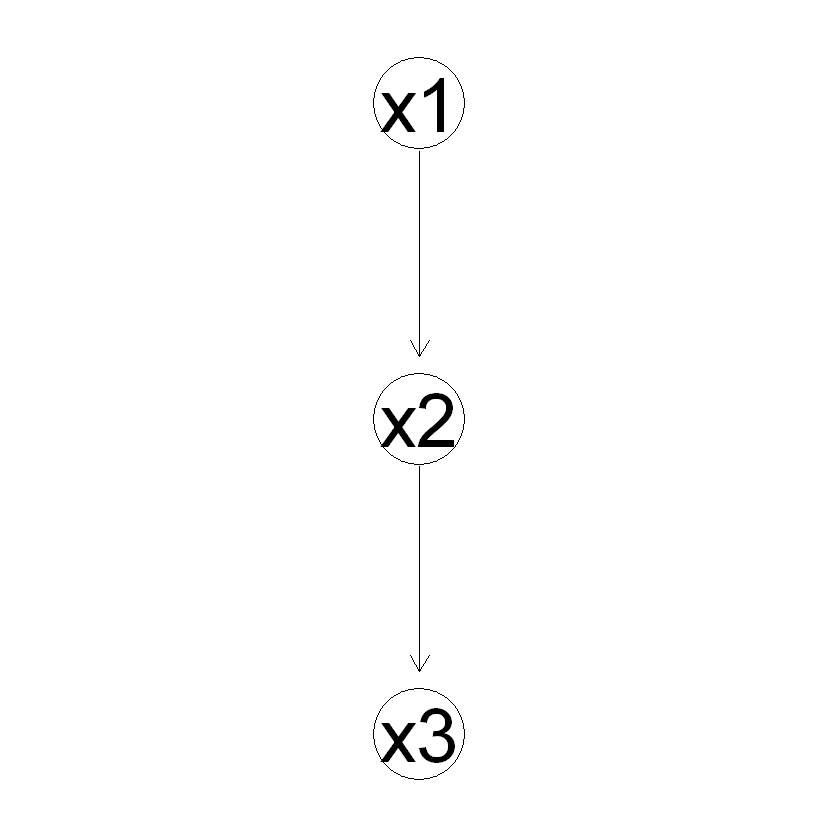

In [7]:
ch93_net <- k2.iter(ch93, parents.nmax=2, f, k2, n.iter=1, seed=1)
graphviz.plot(ch93_net$dag)

Running iteration # 1 ... DONE

Total execution time: 0.2670591 s

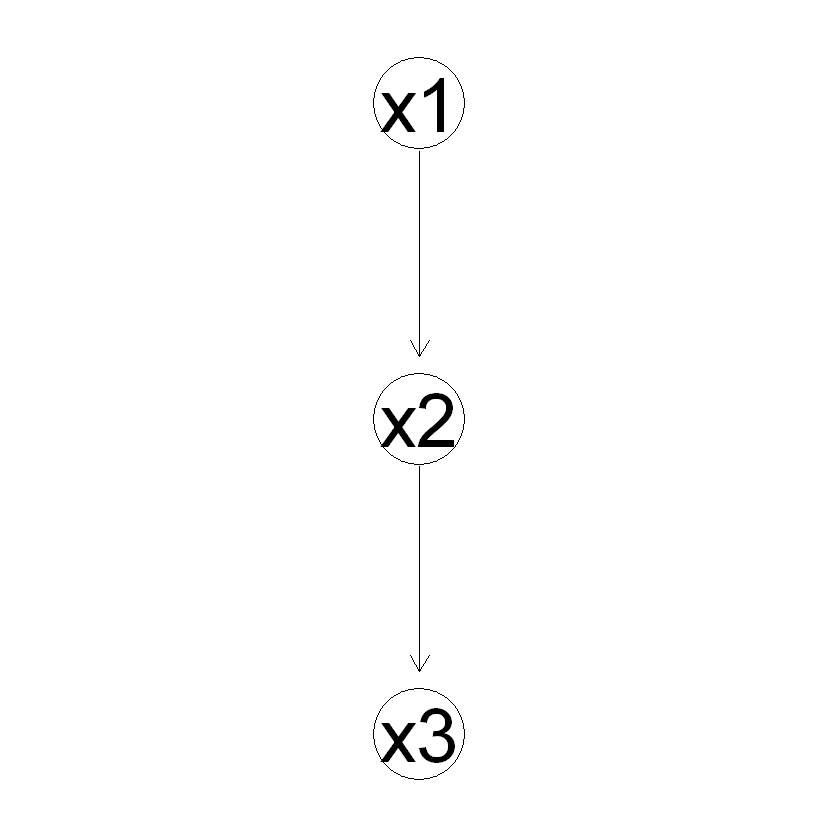

In [8]:
ch93_net <- k2.iter(ch93, parents.nmax=2, log.f, k2, n.iter=1, seed=1)
graphviz.plot(ch93_net$dag)

<a id='sec2.B'></a>
### **2.B** *ASIA*

In [9]:
asia <- read_csv('https://www.ccd.pitt.edu/wiki/images/ASIA10k.csv')
head(asia)

Rows: 10000 Columns: 8
-- Column specification -----------------------------------------------------------------------------------------------
Delimiter: ","
chr (8): asia, tub, smoke, lung, bronc, either, xray, dysp

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


asia,tub,smoke,lung,bronc,either,xray,dysp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,no,no,no,no,no,no,yes
no,no,yes,no,no,no,no,no
no,no,no,no,no,no,no,no
no,no,yes,no,no,no,no,no
no,no,yes,no,yes,no,no,yes
no,no,yes,no,no,no,no,no


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE

Total execution time: 6.83021 s

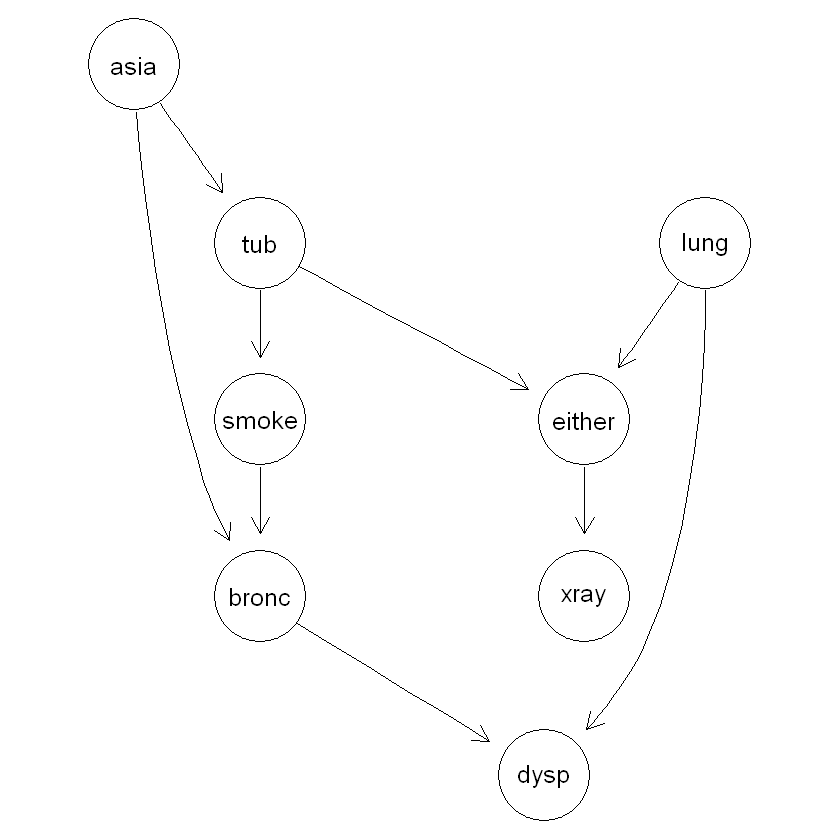

In [10]:
asia_net <- k2.iter(head(asia, 150), parents.nmax=2, f, k2, n.iter=3, seed=1)
graphviz.plot(asia_net$dag)

Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE

Total execution time: 6.98152 s

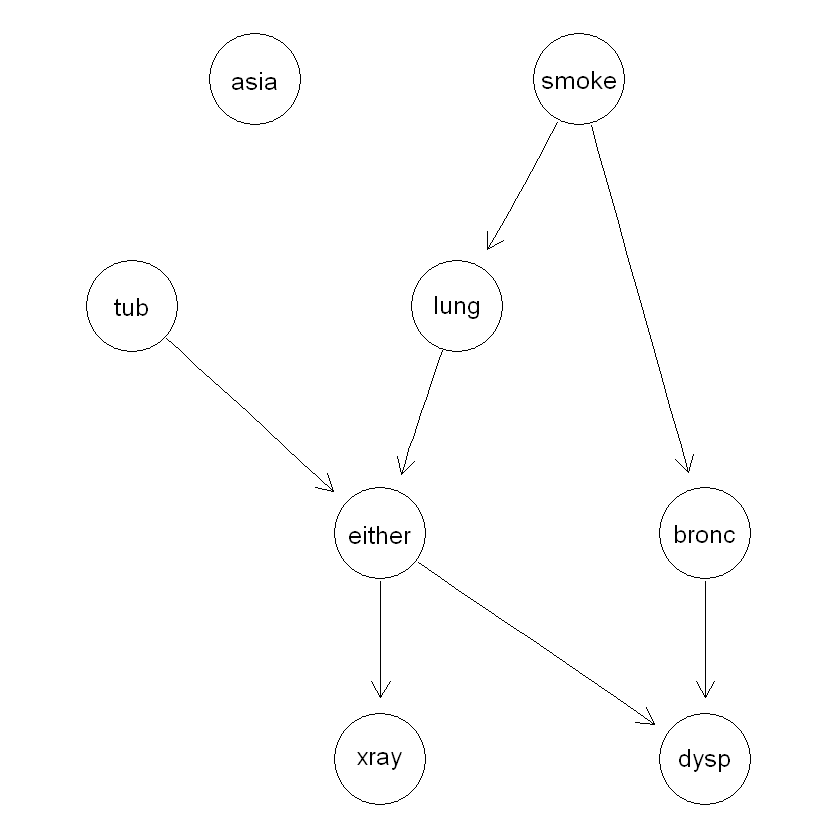

In [11]:
asia_net <- k2.iter(asia, parents.nmax=2, log.f, k2, n.iter=3, seed=1)
graphviz.plot(asia_net$dag)

<a id='sec2.C'></a>
### **2.C** *SACHS*

In [12]:
sachs <- read_csv('https://www.ccd.pitt.edu/wiki/images/SACHS10k.csv')
sachs <- sachs |> select(PKC, Plcg, PKA, PIP3, Raf, Jnk, P38, PIP2, Mek, Erk, Akt)
head(sachs)

Rows: 10000 Columns: 11
-- Column specification -----------------------------------------------------------------------------------------------
Delimiter: ","
dbl (11): Akt, Erk, Jnk, Mek, P38, PIP2, PIP3, PKA, PKC, Plcg, Raf

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


PKC,Plcg,PKA,PIP3,Raf,Jnk,P38,PIP2,Mek,Erk,Akt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,2,2,1,1,1,1,1,1,1
2,1,2,2,1,1,2,1,1,2,1
1,3,1,2,3,3,3,2,1,1,1
1,1,3,3,2,1,1,1,1,2,1
2,2,2,3,1,1,1,1,1,2,1
2,1,2,1,2,2,1,1,2,2,1


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE

Total execution time: 16.92994 s

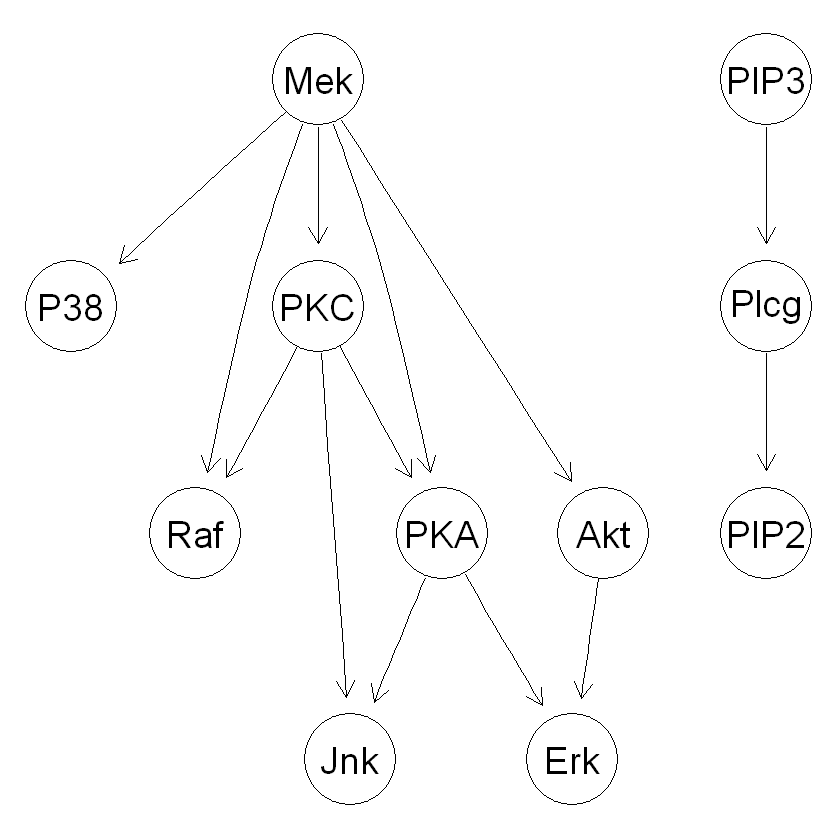

In [13]:
sachs_net <- k2.iter(head(sachs, 150), parents.nmax=3, f, k2, n.iter=3, seed=1)
graphviz.plot(sachs_net$dag)

Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE

Total execution time: 30.11006 s

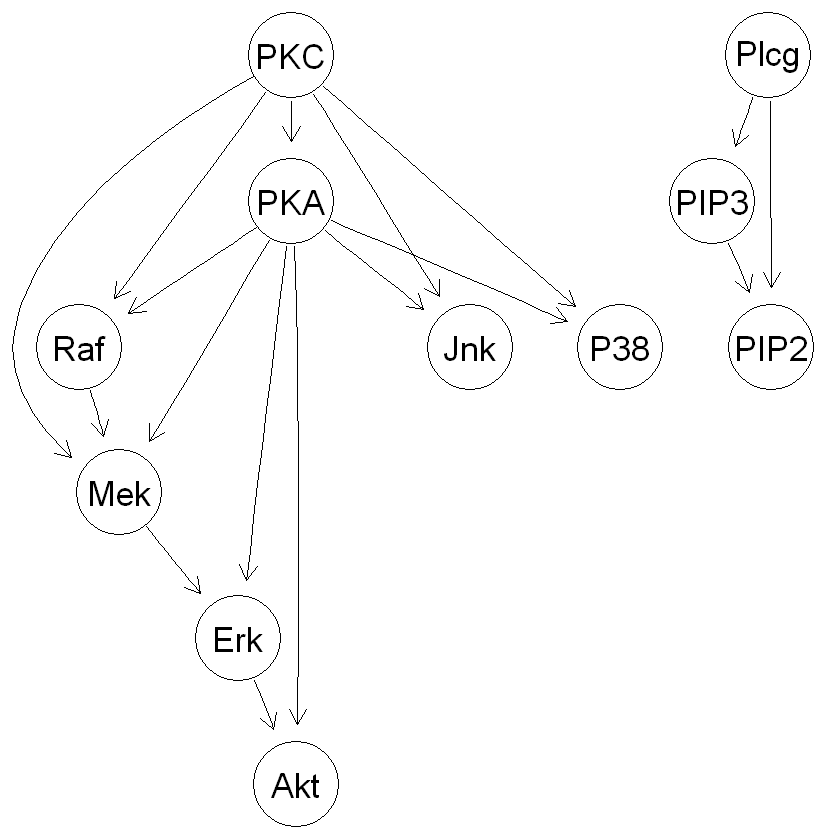

In [14]:
sachs_net <- k2.iter(sachs, parents.nmax=3, log.f, k2, n.iter=3, seed=1)
graphviz.plot(sachs_net$dag)

<a id='sec2.D'></a>
### **2.D** *CHILD*

In [15]:
child <- read_csv('https://www.ccd.pitt.edu/wiki/images/CHILD10k.csv')
child <- child |> select(BirthAsphyxia, Disease, Sick, DuctFlow, CardiacMixing, LungParench, LungFlow, LVH, Age, Grunting, HypDistrib, HypoxiaInO2, CO2, ChestXray, LVHreport, GruntingReport, LowerBodyO2, RUQO2, CO2Report, XrayReport)
head(child)

Rows: 10000 Columns: 20
-- Column specification -----------------------------------------------------------------------------------------------
Delimiter: ","
chr (20): BirthAsphyxia, HypDistrib, HypoxiaInO2, CO2, ChestXray, Grunting, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


BirthAsphyxia,Disease,Sick,DuctFlow,CardiacMixing,LungParench,LungFlow,LVH,Age,Grunting,HypDistrib,HypoxiaInO2,CO2,ChestXray,LVHreport,GruntingReport,LowerBodyO2,RUQO2,CO2Report,XrayReport
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,PAIVS,yes,Lt_to_Rt,Complete,Normal,Low,no,0-3_days,no,Equal,Moderate,Normal,Oligaemic,no,no,5-12,5-12,>=7.5,Grd_Glass
no,TGA,yes,None,Transp.,Abnormal,Low,no,0-3_days,yes,Equal,Severe,Normal,Asy/Patch,no,no,12+,<5,<7.5,Asy/Patchy
no,TGA,yes,None,Transp.,Normal,High,yes,0-3_days,no,Equal,Severe,Normal,Normal,yes,no,12+,5-12,<7.5,Normal
no,Lung,yes,None,Mild,Abnormal,Normal,no,0-3_days,yes,Equal,Moderate,Normal,Asy/Patch,no,yes,5-12,5-12,>=7.5,Asy/Patchy
no,Fallot,no,Lt_to_Rt,Complete,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Normal,no,no,5-12,5-12,<7.5,Normal
no,Fallot,no,Lt_to_Rt,Mild,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Oligaemic,no,yes,5-12,<5,<7.5,Oligaemic


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE

Total execution time: 43.60524 s

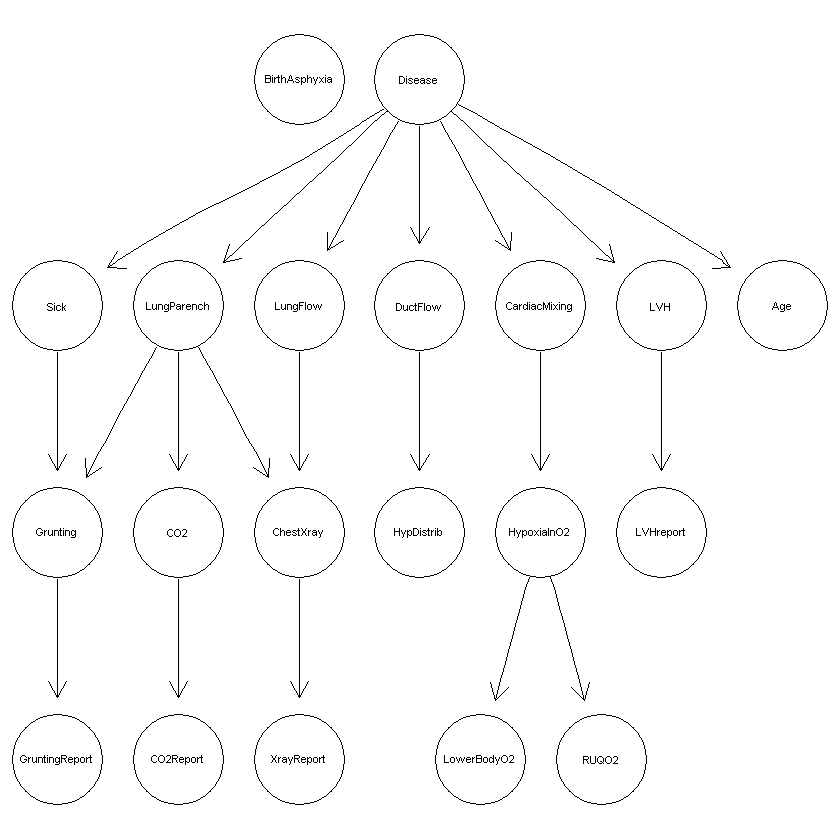

In [16]:
child_net <- k2.iter(head(child, 150), parents.nmax=2, f, k2, n.iter=3, seed=1)
graphviz.plot(child_net$dag)

Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE

Total execution time: 49.46964 s

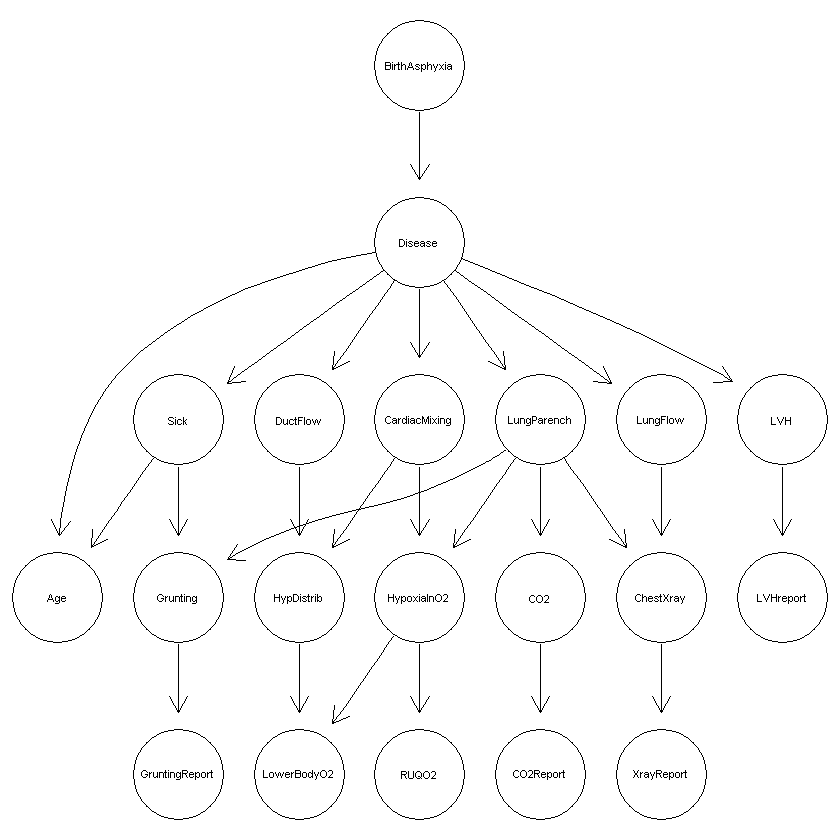

In [17]:
child_net <- k2.iter(child, parents.nmax=2, log.f, k2, n.iter=3, seed=1)
graphviz.plot(child_net$dag)

## **References**

<a id='ref1'></a>
**[1]** M. Scutari and J. B. Denis, *Bayesian Networks*, CRC Press, 2022, Taylor and Francis Group

<a id='ref2'></a>
**[2]** G. F. Cooper and E. Herskovits, *A Bayesian Method for the Induction of Probabilistic Networks from Data*, Machine Learning 9, (1992) 309

<a id='ref3'></a>
**[3]** C. Ruiz, *Illustration of the K2 Algorithm for learning Bayes Net Structures*, http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf

<a id='ref4'></a>
**[4]** A. Franzin et al., *$\texttt{bnstruct}$: an R package for Bayesian Network structure learning in the presence of missing data*, Bioinformatics 33(8) (2017) 1250

<a id='ref5'></a>
**[5]** F. Sambo and A. Franzin, *$\texttt{bnstruct}$: an R package for Bayesian Network Structure Learning with missing data*, December 12, 2016

***

Coded by **Daniele Ninni**

Last edited on 10 July 2022, at 17:20